# Setup

This notebook performs an exploratory data analysis (EDA) of the **CICIDS2017** dataset and builds a baseline anomaly detection model.  

**Goals:**
- Load and consolidate raw CICIDS2017 CSVs.
- Clean and preprocess features into a model-ready matrix `X` and label vector `y`.
- Explore class imbalance and key feature distributions.
- Train and evaluate a baseline model (current implementation: anomaly detection using Isolation Forest and an autoencoder).
- Save figures/metrics to `reports/figures/` for audit and reporting.


In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    precision_recall_fscore_support,
)
import plotly.express as px
import umap
import glob
import os
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
mpl.rcParams['font.family'] = 'DejaVu Sans'

## Load Data

We load all CICIDS2017 CSVs from `../data/raw/MachineLearningCVE`, attach a `Meta_source` column indicating the original capture file, and concatenate them into a single `combined_df`.


In [105]:
# File directory for raw CICIDS2017 CSVs
csv_dir = "../data/raw/MachineLearningCVE"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

dfs = []

# Load each CSV and attach its source as metadata
for filepath in csv_files:
    filename = os.path.basename(filepath).replace(".pcap_ISCX.csv", "")
    df = pd.read_csv(filepath)
    df["Meta_source"] = filename  # attach metadata to each row
    dfs.append(df)

# Combine all days / attack types into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(csv_files)} files into combined_df with shape {combined_df.shape}")

Loaded 8 files into combined_df with shape (2830743, 80)


### Initial dataset inspection

We inspect the combined frame to understand schema, dtypes, and basic label structure before cleaning.

In [107]:
combined_df.info();
display(combined_df.columns);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [108]:
combined_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [109]:
combined_df[' Label'].unique()

array(['BENIGN', 'Infiltration', 'Bot', 'PortScan', 'DDoS', 'FTP-Patator',
       'SSH-Patator', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk',
       'DoS GoldenEye', 'Heartbleed', 'Web Attack � Brute Force',
       'Web Attack � XSS', 'Web Attack � Sql Injection'], dtype=object)

## Cleaning & Feature Engineering

Here we:
- Identify and address missing values and infinities.
- Drop constant / non-informative columns.
- Fix column name formatting.
- Define a numeric feature set (`numeric_cols`) suitable for downstream modeling.

In [111]:
combined_df.columns = combined_df.columns.str.strip()

In [112]:
combined_df[combined_df.isna().any(axis=1)]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Meta_source
18639,52374,0,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Afternoon-Infilteration
54760,30011,0,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Afternoon-Infilteration
74624,51680,0,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Afternoon-Infilteration
91230,33418,0,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Afternoon-Infilteration
93282,443,0,1,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Afternoon-Infilteration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2797653,47072,0,1,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Morning-WebAttacks
2798571,41192,0,2,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Morning-WebAttacks
2806050,50906,0,1,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Morning-WebAttacks
2823831,443,0,1,1,0,0,0,0,0.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,Thursday-WorkingHours-Morning-WebAttacks


In [113]:
nan_counts = combined_df.isna().sum() # identify columns is Nan values
columns_with_nans = nan_counts[nan_counts > 0]
columns_with_nans

Flow Bytes/s    1358
dtype: int64

In [114]:
combined_df['Flow Bytes/s'] = combined_df['Flow Bytes/s'].fillna(0) # filled these columns with 0's

nan_counts = combined_df.isna().sum()
columns_with_nans = nan_counts[nan_counts > 0]
columns_with_nans

Series([], dtype: int64)

In [115]:
constant_columns = [col for col in combined_df.columns if combined_df[col].nunique() == 1]
constant_columns

['Bwd PSH Flags',
 'Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [116]:
combined_df.drop(
    columns=[
        'Bwd PSH Flags',
        'Bwd URG Flags',
        'Fwd Avg Bytes/Bulk',
        'Fwd Avg Packets/Bulk',
        'Fwd Avg Bulk Rate',
        'Bwd Avg Bytes/Bulk',
        'Bwd Avg Packets/Bulk',
        'Bwd Avg Bulk Rate'
    ], 
    inplace=True
)

In [117]:
combined_df.drop(columns=['Fwd Header Length.1'], inplace = True)

In [118]:
combined_df = combined_df.replace([np.inf, -np.inf], np.nan)  # convert inf to NaN
combined_df = combined_df.dropna(subset=['Flow Bytes/s'])

In [119]:
# Get all numeric columns, exclude IAT-related columns
numeric_cols = combined_df.select_dtypes(include=['int64','float64']).columns
exclude_cols = [col for col in numeric_cols if "IAT" in col]
check_cols = [col for col in numeric_cols if col not in exclude_cols]

mask_nonneg = (combined_df[check_cols] >= 0).all(axis=1)
combined_df = combined_df[mask_nonneg]

print(f"After cleaning, combined_df shape: {combined_df.shape}")

After cleaning, combined_df shape: (1388089, 71)


In [120]:
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)


parquet_path = processed_dir / "cicids2017_clean.parquet"
csv_path = processed_dir / "cicids2017_clean.csv"

# Save as parquet (efficient) and optionally as CSV
combined_df.to_parquet(parquet_path, index=False)
combined_df.to_csv(csv_path, index=False)

print(f"Saved cleaned CICIDS2017 to:\n- {parquet_path}\n- {csv_path}")

Saved cleaned CICIDS2017 to:
- ../data/processed/cicids2017_clean.parquet
- ../data/processed/cicids2017_clean.csv


## Exploratory Data Analysis

We summarize label distributions and inspect a few key features to understand traffic behavior and class imbalance.

In [20]:
for col in combined_df.columns:
    if "Packet" in col:
        print(col)

Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow Packets/s
Fwd Packets/s
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
Average Packet Size
Subflow Fwd Packets
Subflow Bwd Packets


### Columns containing "Packet"

Columns containing **"Packet"** describe counts and statistics of packets in each flow:

- **Total** – total number of packets in the forward or backward direction.
- **Mean / Max / Min / Std** – descriptive statistics of packet sizes or counts.
- **`/s` suffix** – per-second rates (e.g., packets per second).
- **Subflow** – metrics over sub-divisions of a TCP/UDP flow.

These features are likely important for distinguishing benign vs attack traffic.

In [22]:
df_labels = combined_df[["Label", "Destination Port"]]
df_agg = df_labels.groupby("Label").count().reset_index()

df_agg.rename(columns={"Destination Port": "Count"}, inplace=True)
df_agg["Relative Frequency"] = df_agg["Count"] / df_agg["Count"].sum()
df_agg.sort_values("Count", ascending=False)

,Label,Count,Relative Frequency
0,BENIGN,953153,0.686666
4,DoS Hulk,164013,0.118157
10,PortScan,158740,0.114359
2,DDoS,81497,0.058712
3,DoS GoldenEye,7714,0.005557
7,FTP-Patator,6443,0.004642
11,SSH-Patator,5885,0.004240
6,DoS slowloris,4154,0.002993
5,DoS Slowhttptest,2327,0.001676
1,Bot,1956,0.001409


**Interpretation – Class Imbalance**

- The dataset is highly imbalanced: **BENIGN** traffic dominates, while some attack types have orders of magnitude fewer samples.
- This imbalance motivates:
  - Using metrics like **precision–recall** instead of accuracy.
  - Considering techniques like stratification, resampling, or anomaly detection models.

### IAT (Inter-Arrival Time) feature family

The CICIDS2017 dataset includes a family of inter-arrival time (IAT) features
(e.g., `Flow IAT Mean`, `Fwd IAT Max`, `Bwd IAT Std`). These are often
heavy-tailed and can take negative or near-zero values depending on how they
were computed. For this reason, we:
- Treat IAT features as a distinct family in EDA.
- Exclude them from the non-negativity filter we apply to other numeric fields.


### Feature Families Overview

This section summarizes the key feature families in CICIDS2017 and why they are relevant for intrusion detection.

**1. Flow metadata**
- Examples: `Destination Port`, `Flow Duration`, `Flow Bytes/s`
- Meaning: High-level properties of each flow (port, duration, throughput).
- Relevance: Well-known ports (22, 80, 443) map to common services; long-lived, high-throughput flows may indicate data transfer or tunneling.

**2. TCP flags**
- Examples: `Fwd PSH Flags`, `Fwd URG Flags`, `FIN Flag Count`, `SYN Flag Count`, `ACK Flag Count`, `RST Flag Count`, `PSH Flag Count`, `URG Flag Count`, `CWE Flag Count`, `ECE Flag Count`
- Meaning: Counters of TCP control flags within the flow.
- Relevance: SYN floods (DoS) → many SYNs; frequent RST → scans or failed connections; rare flags (CWE/ECE) can signal unusual behavior.

**3. Header and segment sizes**
- Examples: `Fwd Header Length`, `Bwd Header Length`, `Avg Fwd Segment Size`, `Avg Bwd Segment Size`, `act_data_pkt_fwd`, `min_seg_size_forward`
- Meaning: Sizes of headers and TCP segments, and counts of packets carrying data.
- Relevance: Very small or crafted segments may indicate scanning/evasion; large segments often correspond to bulk transfers.

**4. Subflow statistics**
- Examples: `Subflow Fwd Bytes`, `Subflow Bwd Bytes`
- Meaning: Byte counts within subflows (TCP/UDP subdivisions).
- Relevance: Can reflect retransmissions, segmentation anomalies, or protocol misuse.

**5. Window sizes**
- Examples: `Init_Win_bytes_forward`, `Init_Win_bytes_backward`
- Meaning: Initial TCP window sizes.
- Relevance: May be used for OS/application fingerprinting; some malware families use unusual window sizes.

**6. Temporal activity (active / idle times)**
- Examples: `Active Mean`, `Active Std`, `Active Max`, `Active Min`, `Idle Mean`, `Idle Std`, `Idle Max`, `Idle Min`
- Meaning: Summary of bursts of activity vs silence within the flow.
- Relevance: Bot/C2 traffic often has regular idle–active patterns; human-driven traffic is more irregular.

**7. Labels and metadata**
- `Label`: Ground-truth class (benign vs specific attack types).
- `Meta_source`: Originating capture/file for the record (dataset split / capture day).


### Total Forward Packets vs Label


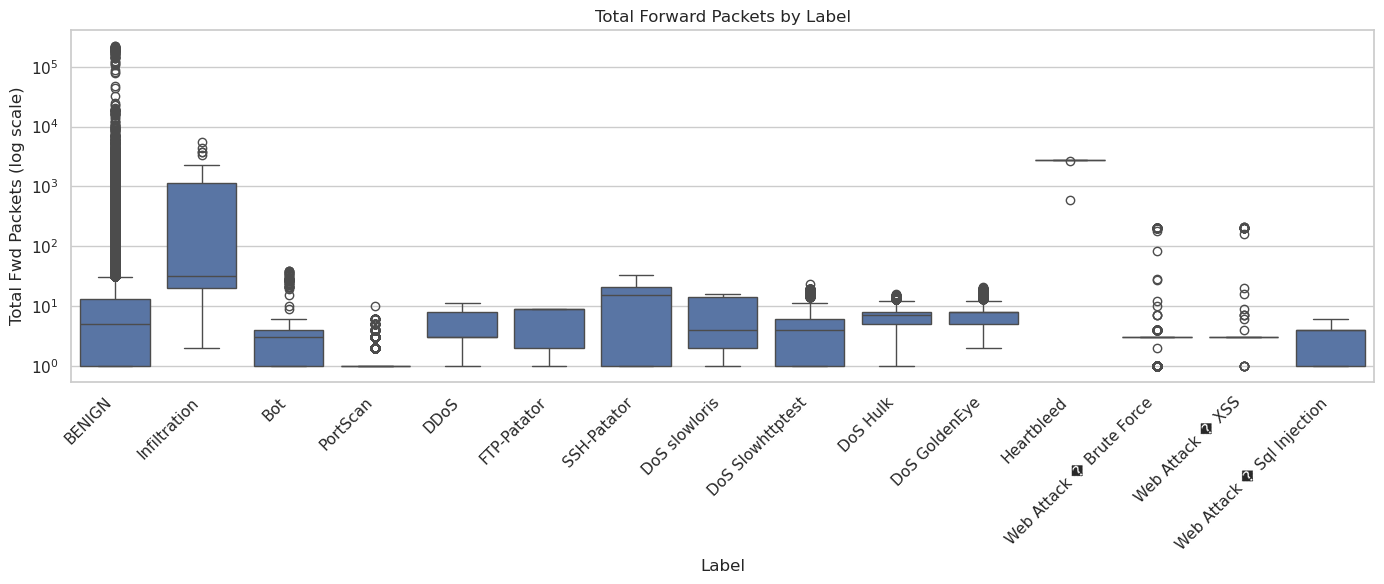

In [27]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df, x="Label", y="Total Fwd Packets")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.ylabel("Total Fwd Packets (log scale)")
plt.title("Total Forward Packets by Label")
plt.tight_layout()
plt.show()

**Interpretation**

- Many attack types show heavier tails in **Total Fwd Packets** compared to benign traffic.
- Log scaling reveals that certain attacks (e.g., volumetric DoS) can generate significantly more packets per flow.


### Total Backward Packets vs Label

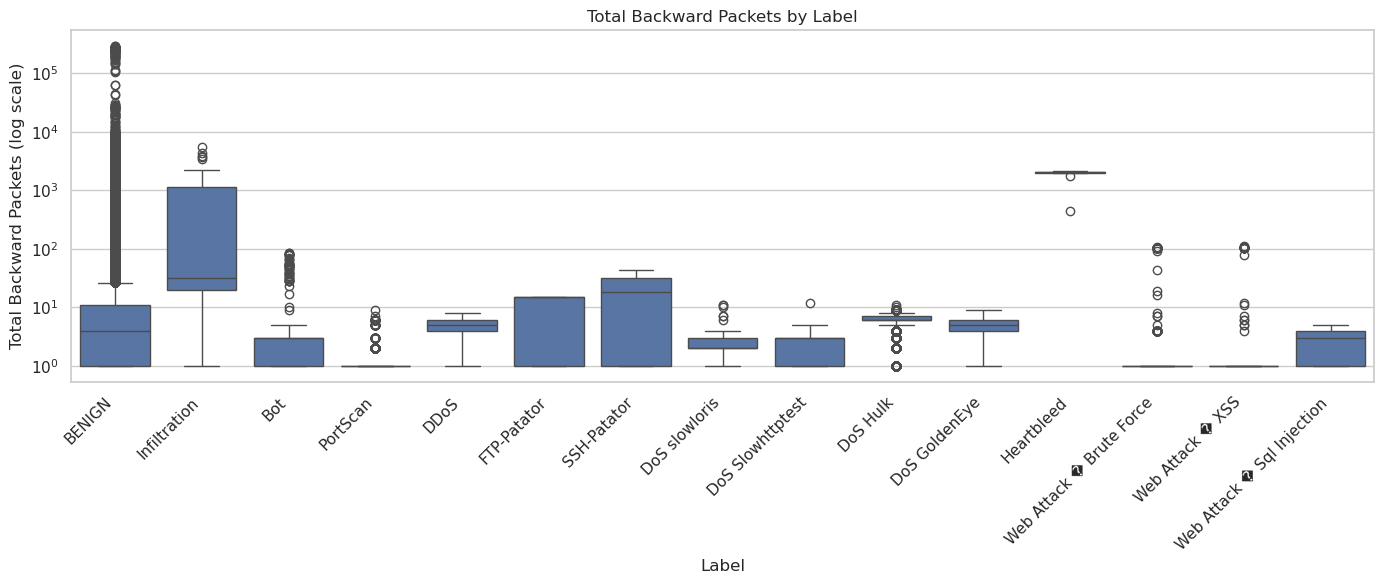

In [30]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df, x="Label", y="Total Backward Packets")
plt.xticks(rotation=45, ha="right")
plt.yscale("log")
plt.ylabel("Total Backward Packets (log scale)")
plt.title("Total Backward Packets by Label")
plt.tight_layout()
plt.show()

**Interpretation**

- Some attack categories reply with large numbers of backward packets (e.g., scanning or handshake-heavy behavior).
- As with forward packets, the distribution is highly skewed, reinforcing the need for robust scaling before modeling.


### Correlation structure of numeric features


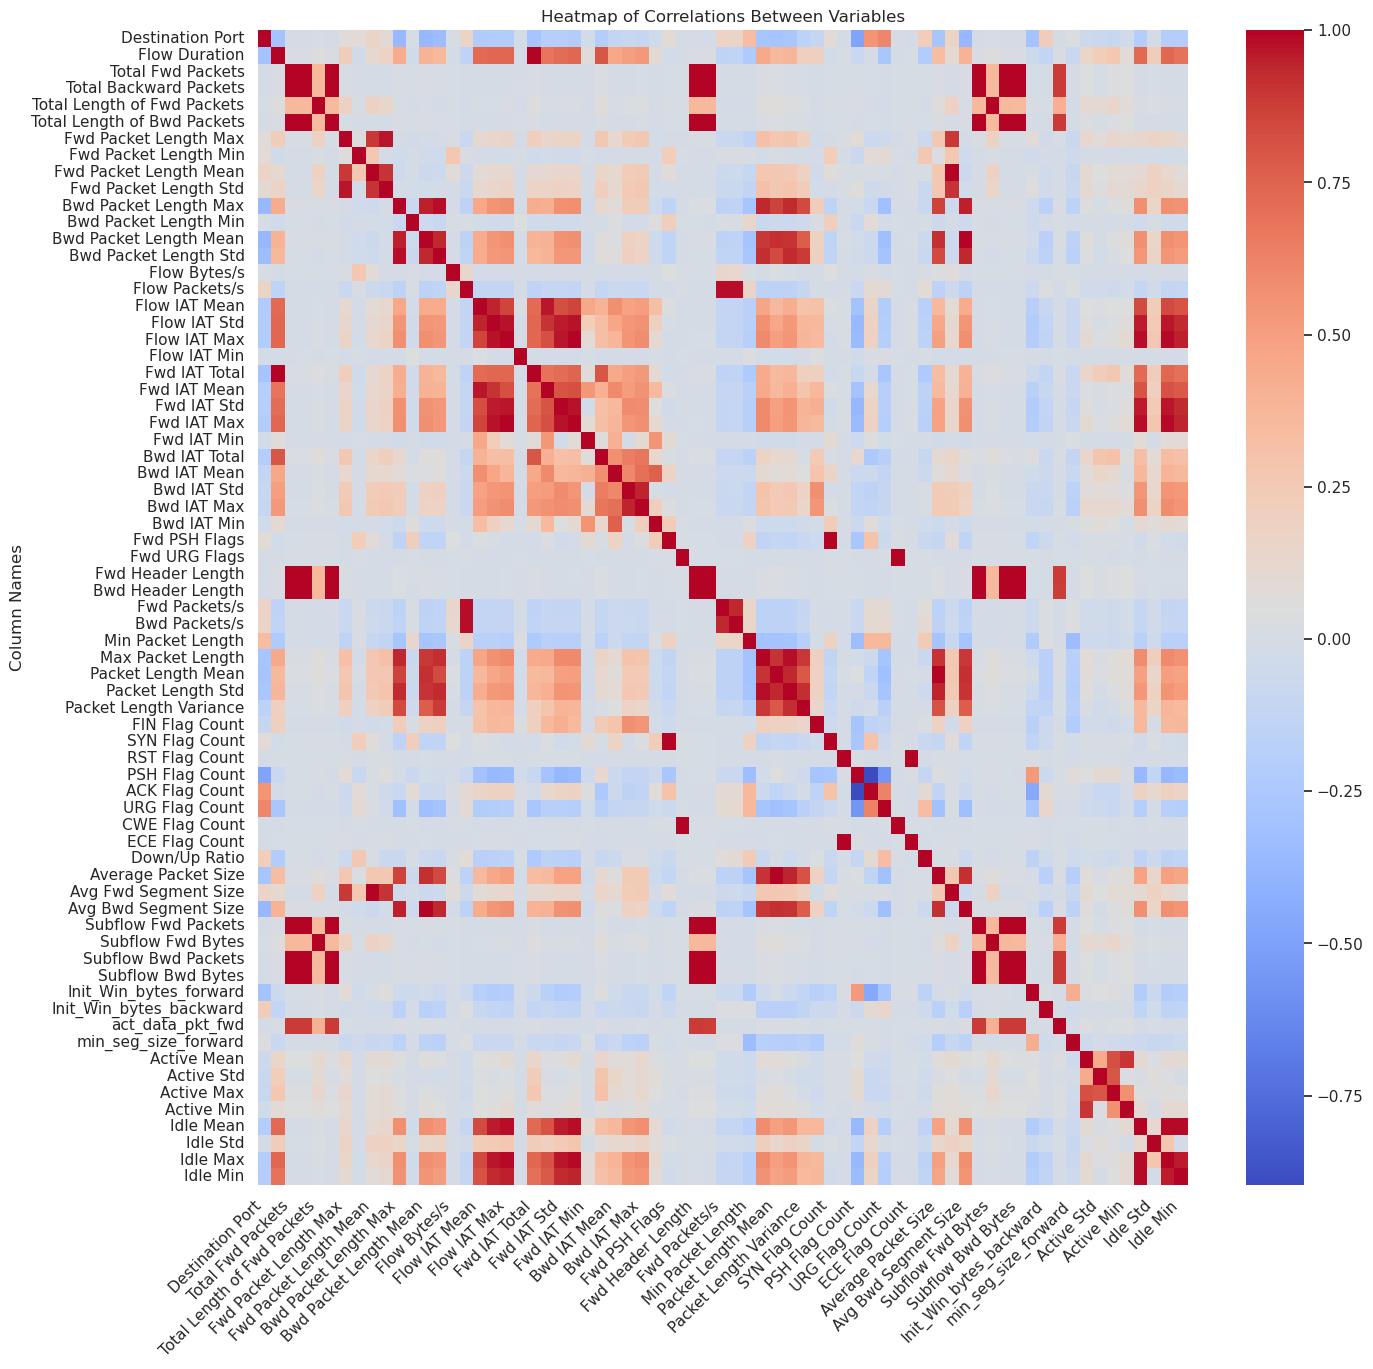

In [33]:
numeric_data = combined_df.select_dtypes([int, float]).corr()

plt.figure(figsize=(15, 15))
sns.heatmap(data=numeric_data, cmap="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Column Names")
plt.title("Heatmap of Correlations Between Variables")
plt.show()

**Interpretation**

- Forward/backward variants of similar features (e.g., bytes, packets, IAT statistics) cluster together with high correlation.
- This suggests:
  - Possible dimensionality reduction (PCA/UMAP) before modeling.
  - Regularization or feature selection to avoid multicollinearity issues.


### Sampled visualization (PCA / UMAP / PairPlots)

To keep plots readable, we down-sample each class and visualize structure in lower dimensions.


In [36]:
# Sample up to 2000 rows per label for visualization
sample_df = combined_df.groupby("Label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 2000), random_state=1)
)

/var/folders/yq/9hnvq27x6lq2z27v61w8bkjh0000gn/T/ipykernel_25586/963035319.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = combined_df.groupby("Label", group_keys=False).apply(


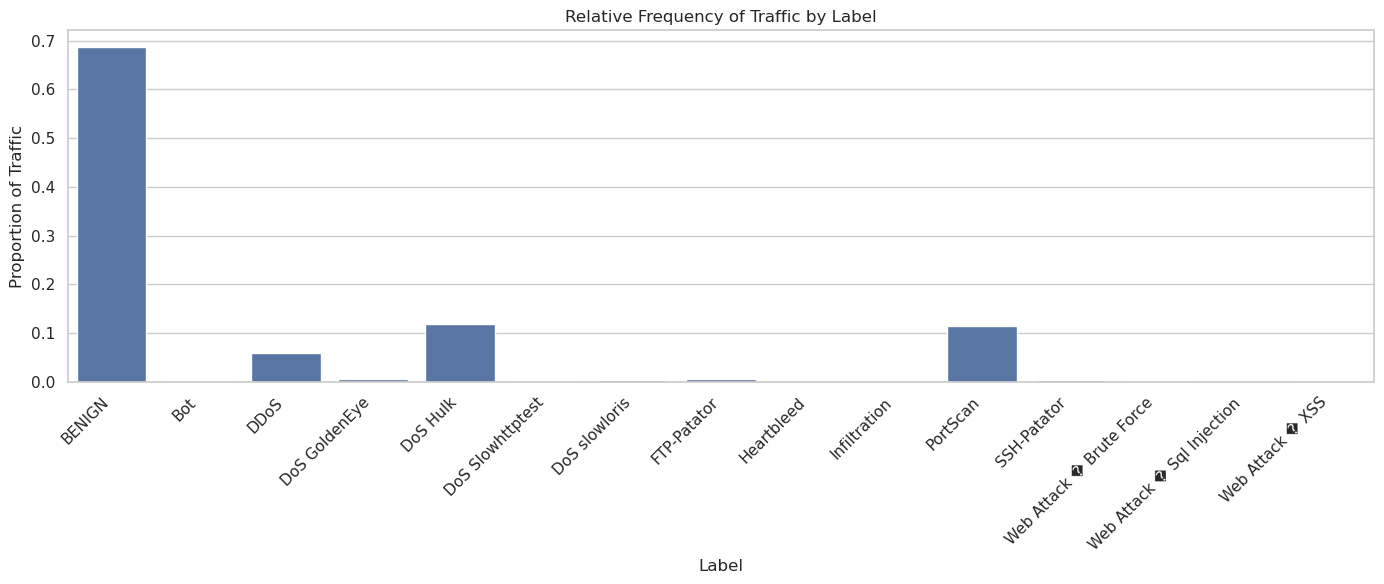

In [37]:
# create frequency table
df = combined_df[['Label', 'Destination Port']]  
df_agg = df.groupby('Label').count().reset_index()

# rename count column for clarity
df_agg.rename(columns={'Destination Port': 'Count'}, inplace=True)

# add a column for relative frequency
df_agg['Relative Frequency'] = df_agg['Count'] / df_agg['Count'].sum()

# barplot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_agg, x='Label', y='Relative Frequency')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Proportion of Traffic")
plt.title("Relative Frequency of Traffic by Label")
plt.tight_layout()
plt.show()

In [38]:
combined_df['Total Fwd Packets'].describe()

count    1.388089e+06
mean     1.668178e+01
std      1.070499e+03
min      1.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      2.197590e+05
Name: Total Fwd Packets, dtype: float64

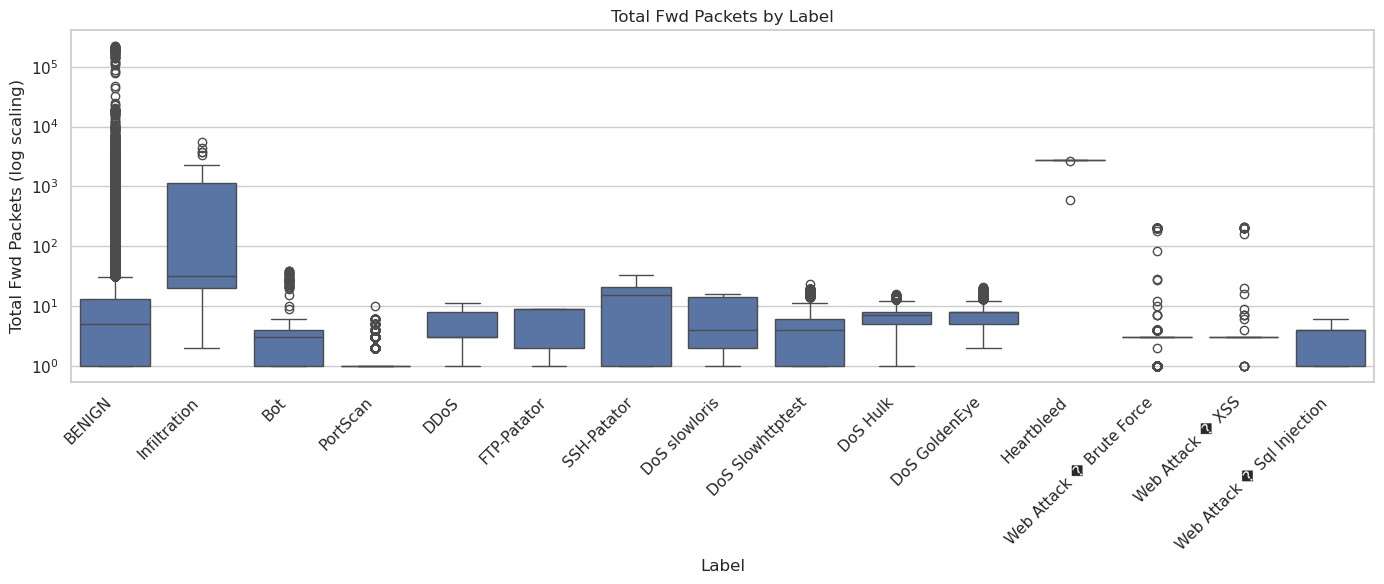

In [39]:
# boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df, x ='Label', y='Total Fwd Packets');
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Total Fwd Packets (log scaling)")
plt.title("Total Fwd Packets by Label")
plt.tight_layout()
plt.show()

>Notice that Infiltration Labels have a higher than begign Total Fwd Packets. 

In [41]:
X_sample = StandardScaler().fit_transform(sample_df[numeric_cols])
y_sample = sample_df["Label"]

### 2-D PCA Sample

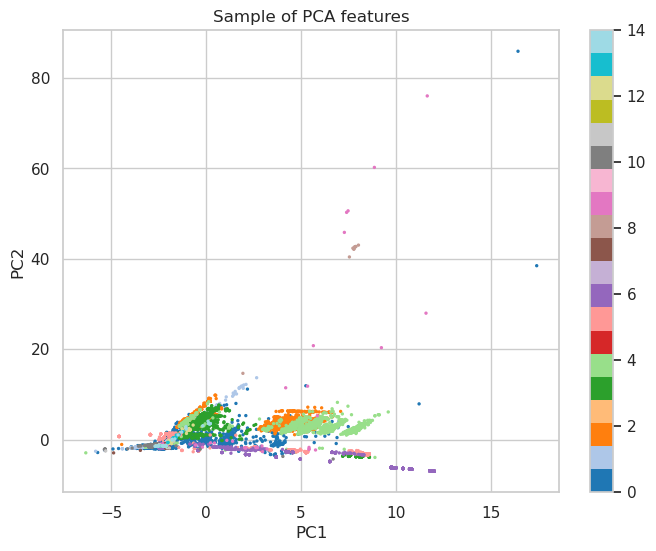

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

X_pca2 = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y_sample.astype('category').cat.codes, cmap='tab20', s=2)
plt.title("Sample of PCA features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()

### **UMAP 2-D**

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 1020 with accuracies 
[3.12972801e-13 9.14966072e-07 3.05537490e-06 2.52501480e-06]
not reaching the requested tolerance 2.816319465637207e-06.
Use iteration 1020 instead with accuracy 
1.6238390222230372e-06.

  _, diffusion_map = lobpcg(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.26563147e-13 9.14967270e-07 3.05537456e-06 2.52501479e-06]
not reaching the requested tolerance 2.816319465637207e-06.
  _, diffus

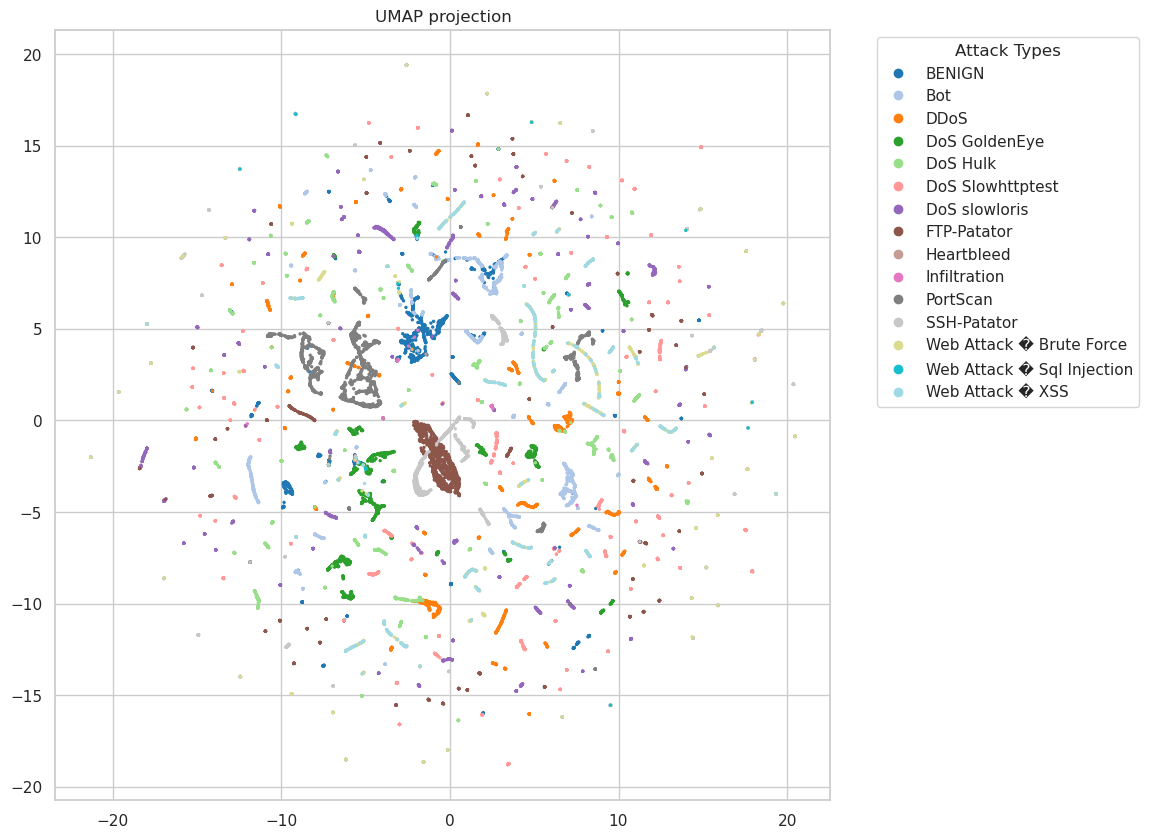

In [58]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sample)

# 3. Plot UMAP
labels = sample_df['Label'].astype('category')
codes = labels.cat.codes
unique_labels = labels.cat.categories

plt.figure(figsize=(10,10))
scatter = plt.scatter(
    X_umap[:,0], 
    X_umap[:,1], 
    c=codes, 
    cmap='tab20', 
    s=2
)
# Build a legend mapping colors to label names
handles, _ = scatter.legend_elements(num=len(unique_labels))
plt.legend(handles, unique_labels, title="Attack Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP projection")
plt.show()

**Interpretation**

- Even in 2D projections, benign and several attack families occupy overlapping but distinguishable regions.
- Some rare attack types overlap strongly with benign traffic, which is one reason anomaly detection can be challenging.

### PairPlot of selected numeric features


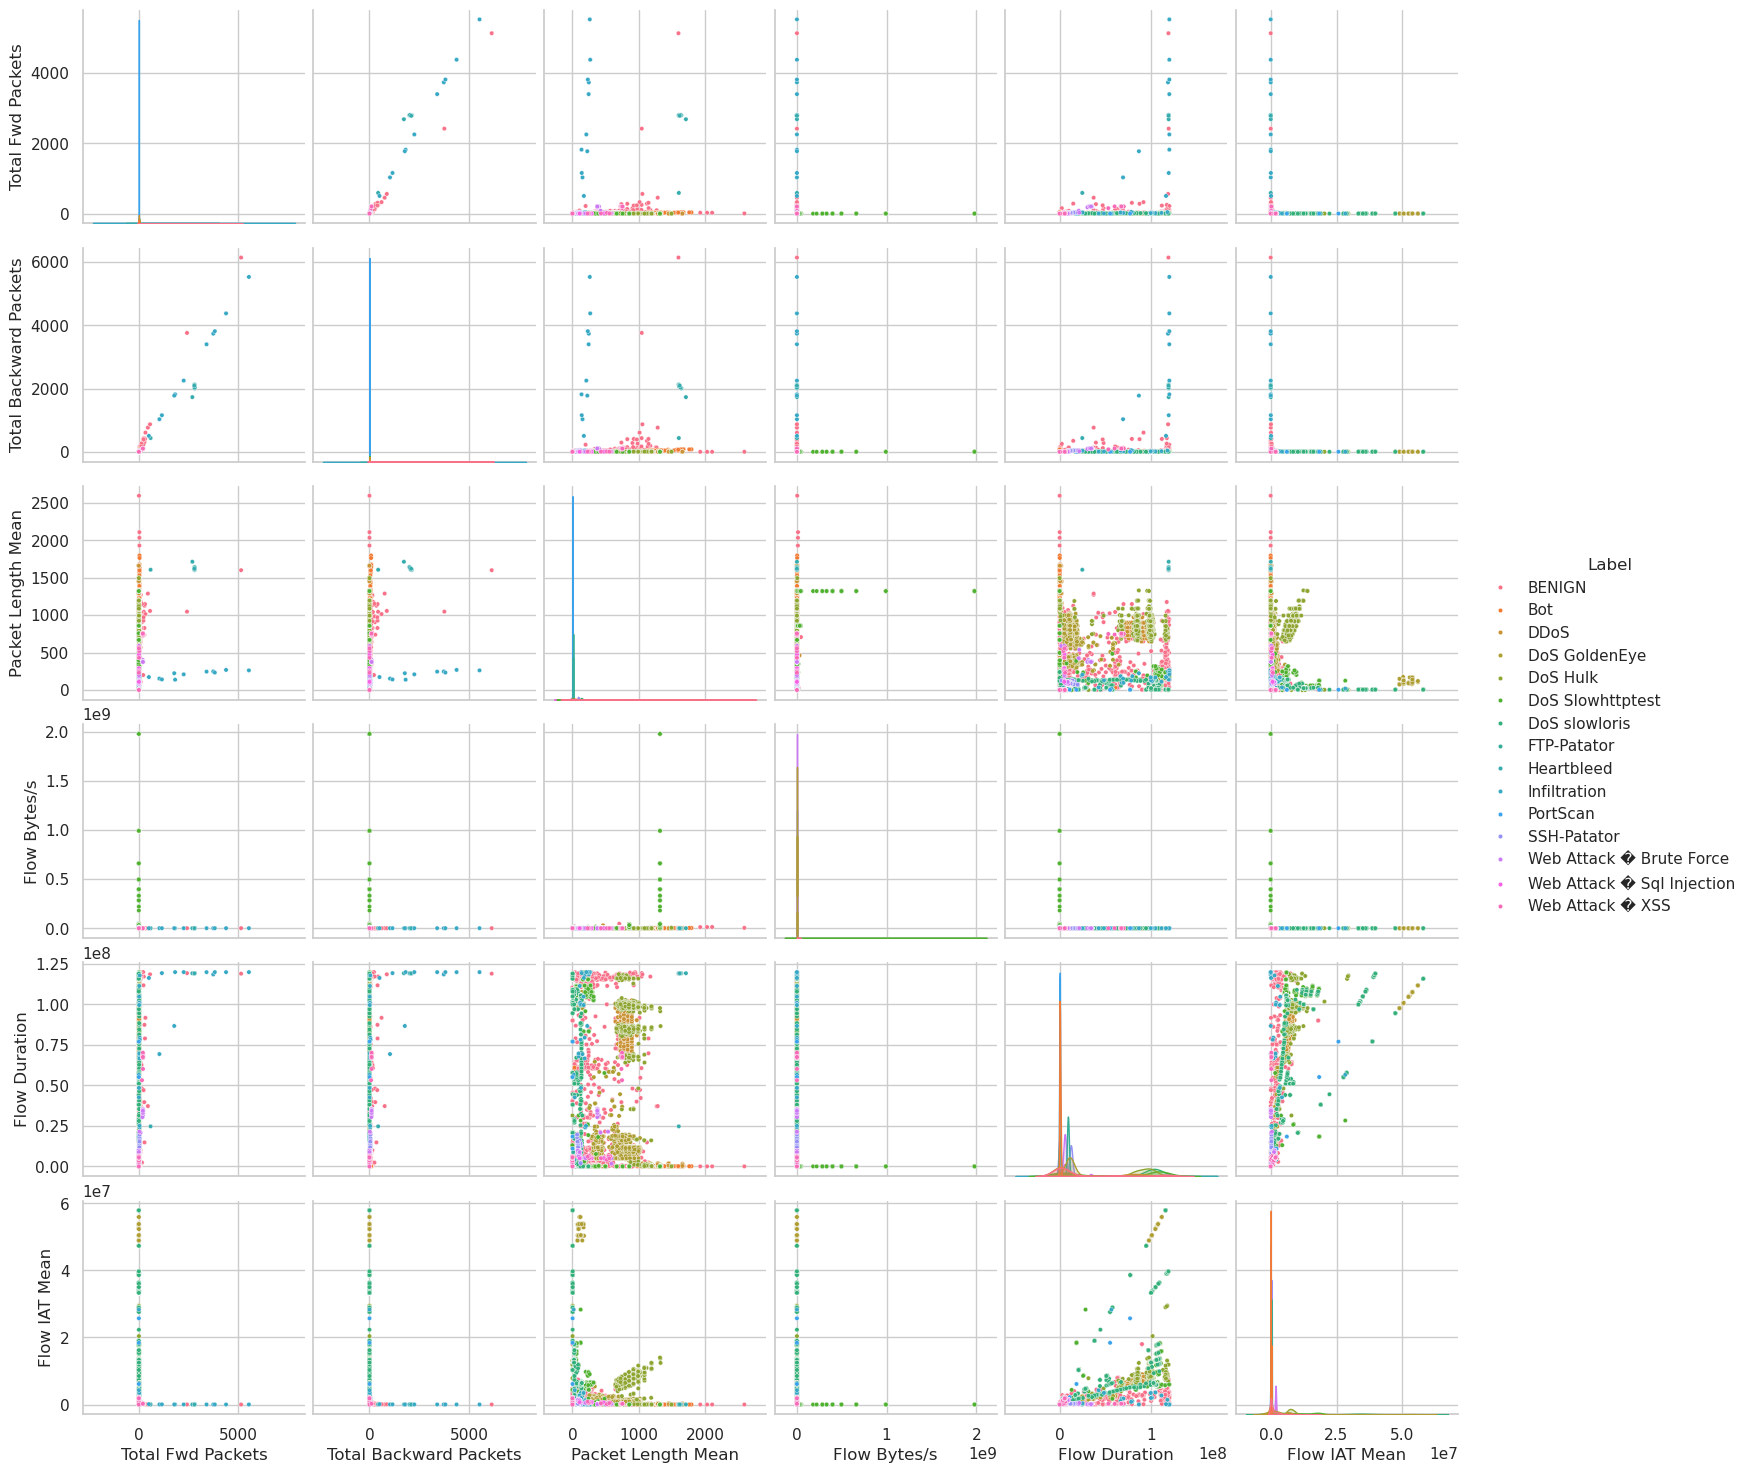

In [62]:
features = [
    "Total Fwd Packets",
    "Total Backward Packets",
    "Packet Length Mean",
    "Flow Bytes/s",
    "Flow Duration",
    "Flow IAT Mean",
]

sns.pairplot(sample_df[features + ["Label"]], hue="Label", plot_kws={"s": 10})

**Interpretation**

- Certain attack families show distinct clusters in feature space (e.g., very high `Flow Bytes/s` or `Flow Duration`).
- Others are closer to benign, motivating more sophisticated models or additional features.


### Outlier scan (z-score > 3)

We scan for extreme outliers per numeric feature using a simple z-score rule.


In [95]:
for col in numeric_cols:
    z_scores = (combined_df[col] - combined_df[col].mean()) / combined_df[col].std()
    outliers = combined_df[np.abs(z_scores) > 3]
    if len(outliers) > 0.05 * combined_df.shape[0]:
        print(f"Found {len(outliers)} outliers in {col}")

Found 70638 outliers in Fwd PSH Flags
Found 76972 outliers in FIN Flag Count
Found 70638 outliers in SYN Flag Count


**Interpretation**

- Flag and count-based features naturally produce many “outliers” due to their discrete/0–1 nature.
- We treat these as signal rather than noise; the main cleaning step avoids impossible values (negative or infinite).


### Baseline model data preparation

We construct a binary label (0 = benign, 1 = attack), clean infinities/NaNs, optionally
downsample the benign class to reduce imbalance and runtime, then create a stratified
train/test split with standardized numeric features. The resulting arrays are reused
by both baseline models.


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import os
import numpy as np

# 1. Clean infinities / NaNs for modeling
df_model = combined_df.replace([np.inf, -np.inf], np.nan)
df_model = df_model.dropna(subset=list(numeric_cols) + ["Label"])

# 2. Binary label: 1 = attack, 0 = benign
y_binary = (df_model["Label"] != "BENIGN").astype(int).values

# 3. Numeric feature matrix
X = df_model[numeric_cols].values

# 4. Optional: downsample benign class for efficiency and reduced imbalance
max_benign = 200_000  # adjust based on your hardware / patience

benign_idx = np.where(y_binary == 0)[0]
attack_idx = np.where(y_binary == 1)[0]

if len(benign_idx) > max_benign:
    rng = np.random.RandomState(42)
    benign_idx_sampled = rng.choice(benign_idx, size=max_benign, replace=False)
    keep_idx = np.concatenate([benign_idx_sampled, attack_idx])
    X = X[keep_idx]
    y_binary = y_binary[keep_idx]

print(f"Total samples after optional downsampling: {X.shape[0]:,}")
print(f"Attack rate overall: {y_binary.mean():.3f}")

# 5. Train/test split (stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42,
)

# 6. Standardize features based on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")
print(f"Attack rate in train: {y_train.mean():.3f}, in test: {y_test.mean():.3f}")


Total samples after optional downsampling: 634,936
Attack rate overall: 0.685
Train shape: (507948, 69), Test shape: (126988, 69)
Attack rate in train: 0.685, in test: 0.685


### Logistic Regression baseline (supervised)

We train a regularized logistic regression classifier on numeric features:

- 5-fold StratifiedKFold on the training split (PR-AUC per fold).
- Final fit on the full training set and evaluation on the held-out test set.
- Metrics: classification report, confusion matrix, PR-AUC, and precision–recall curve.


Fold 1 PR-AUC: 0.996
Fold 2 PR-AUC: 0.996
Fold 3 PR-AUC: 0.996
Fold 4 PR-AUC: 0.996
Fold 5 PR-AUC: 0.995

Mean PR-AUC (5-fold): 0.996 ± 0.000

Test set classification report (Logistic Regression):
              precision    recall  f1-score   support

      benign       0.92      0.95      0.93     40000
      attack       0.97      0.96      0.97     86988

    accuracy                           0.96    126988
   macro avg       0.95      0.95      0.95    126988
weighted avg       0.96      0.96      0.96    126988



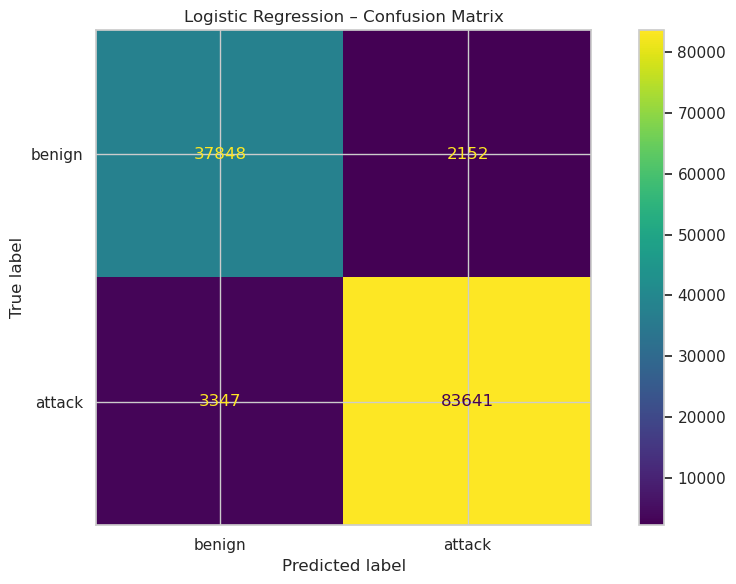

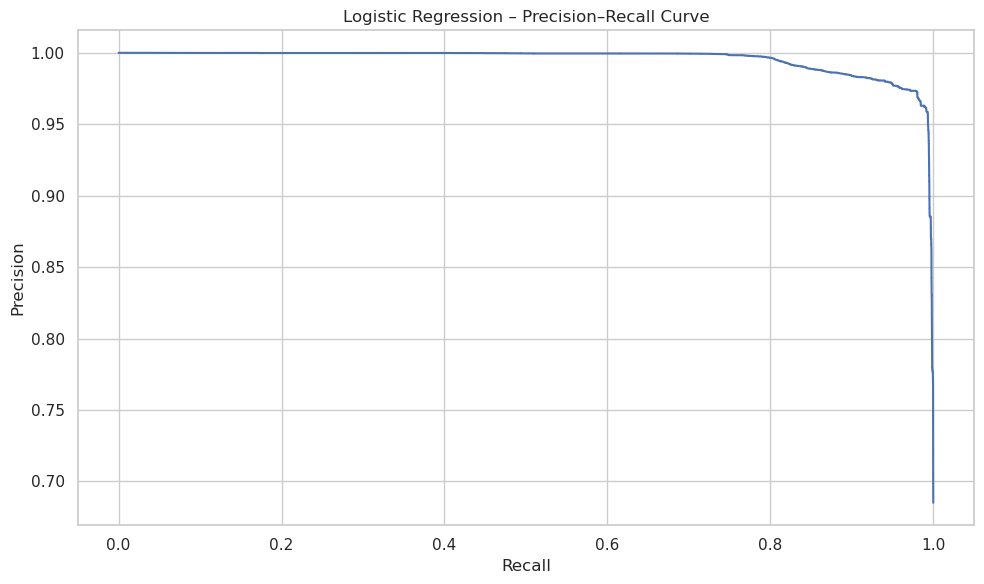

Logistic Regression PR-AUC (test): 0.996


In [94]:
log_reg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pr_aucs = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_scaled, y_train), start=1):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    log_reg.fit(X_tr, y_tr)
    y_val_proba = log_reg.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, y_val_proba)
    pr_aucs.append(pr_auc)

    print(f"Fold {fold} PR-AUC: {pr_auc:.3f}")

print(f"\nMean PR-AUC (5-fold): {np.mean(pr_aucs):.3f} ± {np.std(pr_aucs):.3f}")

log_reg.fit(X_train_scaled, y_train)
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
y_test_pred = log_reg.predict(X_test_scaled)

print("\nTest set classification report (Logistic Regression):")
print(classification_report(y_test, y_test_pred, target_names=["benign", "attack"]))

# Confusion Matrix - shown at the end
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["benign", "attack"])
disp.plot(values_format="d")
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision–Recall curve - shown at the end
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Logistic Regression – Precision–Recall Curve")
plt.tight_layout()

os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/logreg_pr_curve.png", bbox_inches="tight")
plt.show()

logreg_pr_auc = average_precision_score(y_test, y_test_proba)
print(f"Logistic Regression PR-AUC (test): {logreg_pr_auc:.3f}")

### Isolation Forest baseline (unsupervised anomaly detection)

We train an Isolation Forest using only benign flows from the training set and
treat high anomaly scores on the test set as attacks:

- Trained on benign-only training data.
- Evaluated on the same test split as logistic regression.
- Metrics: precision, recall, F1, PR-AUC, confusion matrix, and PR curve.


Isolation Forest – Precision: 0.922, Recall: 0.400, F1: 0.558
Isolation Forest – PR-AUC (test): 0.859

Test set classification report (Isolation Forest):
              precision    recall  f1-score   support

      benign       0.42      0.93      0.57     40000
      attack       0.92      0.40      0.56     86988

    accuracy                           0.57    126988
   macro avg       0.67      0.66      0.57    126988
weighted avg       0.76      0.57      0.56    126988



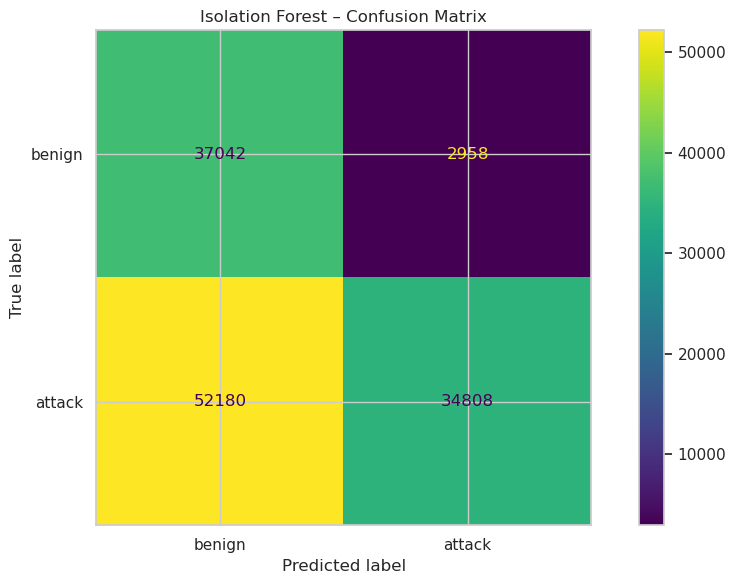

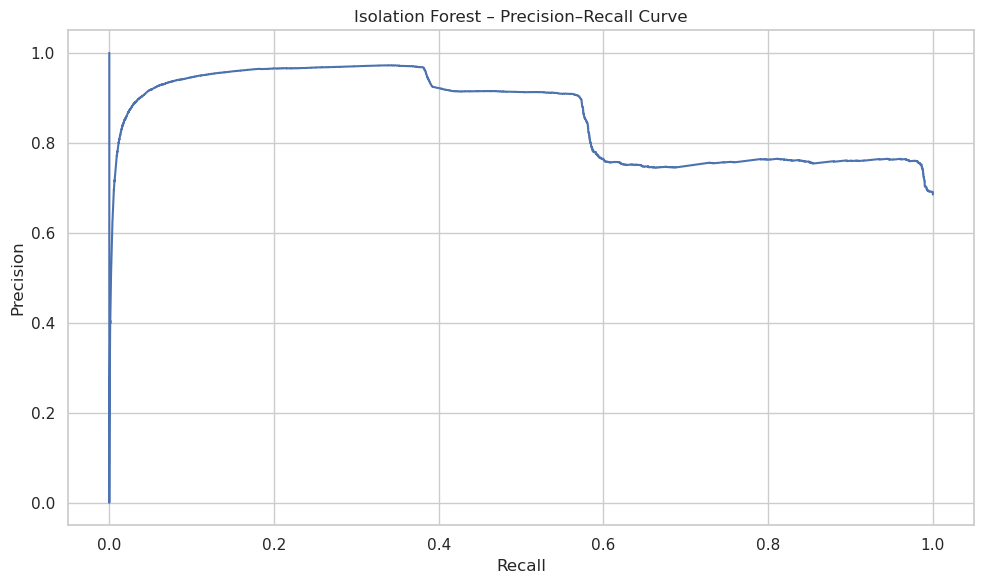

In [91]:
# Train Isolation Forest only on benign flows from the training set
benign_mask_train = (y_train == 0)
X_train_benign = X_train_scaled[benign_mask_train]

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination="auto",  # model estimates contamination - point of optimization
    random_state=42,
    n_jobs=-1,
)

iso_forest.fit(X_train_benign)

# Score and predict on the test set
iso_scores = -iso_forest.decision_function(X_test_scaled)  # higher = more anomalous
iso_preds_raw = iso_forest.predict(X_test_scaled)          # 1 = normal, -1 = anomaly
iso_y_pred = (iso_preds_raw == -1).astype(int)             # 1 = attack, 0 = benign

precision_iso, recall_iso, f1_iso, _ = precision_recall_fscore_support(
    y_test, iso_y_pred, average="binary"
)
iso_pr_auc = average_precision_score(y_test, iso_scores)

print(f"Isolation Forest – Precision: {precision_iso:.3f}, Recall: {recall_iso:.3f}, F1: {f1_iso:.3f}")
print(f"Isolation Forest – PR-AUC (test): {iso_pr_auc:.3f}")

print("\nTest set classification report (Isolation Forest):")
print(classification_report(y_test, iso_y_pred, target_names=["benign", "attack"]))

# Confusion Matrix - shown at the end
cm_iso = confusion_matrix(y_test, iso_y_pred)
disp_iso = ConfusionMatrixDisplay(confusion_matrix=cm_iso, display_labels=["benign", "attack"])
disp_iso.plot(values_format="d")
plt.title("Isolation Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision–Recall curve - shown at the end
precision_iso_curve, recall_iso_curve, _ = precision_recall_curve(y_test, iso_scores)
plt.plot(recall_iso_curve, precision_iso_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Isolation Forest – Precision–Recall Curve")
plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/iso_forest_pr_curve.png", bbox_inches="tight")
plt.show()

## Evaluation & Metrics

We compare two baseline detectors on the held-out test set:

- **Logistic Regression (supervised)** – trained on labeled benign vs attack flows with class-balanced loss.
- **Isolation Forest (unsupervised)** – trained on benign-only flows and used to flag anomalous traffic.

We report precision, recall, F1, and PR-AUC for the attack class and inspect confusion
matrices and precision–recall curves for both models.


In [74]:
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="binary"
)
logreg_pr_auc = average_precision_score(y_test, y_test_proba)

precision_iso, recall_iso, f1_iso, _ = precision_recall_fscore_support(
    y_test, iso_y_pred, average="binary"
)
iso_pr_auc = average_precision_score(y_test, iso_scores)

summary = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Isolation Forest"],
        "Precision (attack)": [precision_lr, precision_iso],
        "Recall (attack)": [recall_lr, recall_iso],
        "F1 (attack)": [f1_lr, f1_iso],
        "PR-AUC (attack)": [logreg_pr_auc, iso_pr_auc],
    }
)

summary.set_index("Model", inplace=True)
summary.round(3)

,Precision (attack),Recall (attack),F1 (attack),PR-AUC (attack)
Model,,,,
Logistic Regression,0.975,0.962,0.968,0.996
Isolation Forest,0.922,0.400,0.558,0.859


**Summary**

- **Logistic Regression** achieves very high PR-AUC (~0.996) with both high precision
  and high recall on attacks. It is a strong supervised baseline on CICIDS2017.
- **Isolation Forest** reaches high precision on attacks but substantially lower recall
  (~0.40), meaning many attacks are not detected. This behavior is expected for a
  conservative anomaly detector trained only on benign traffic.


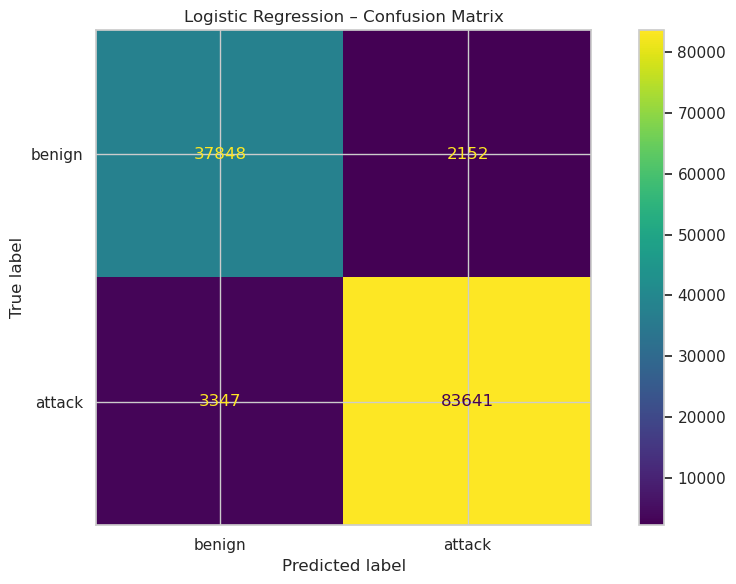

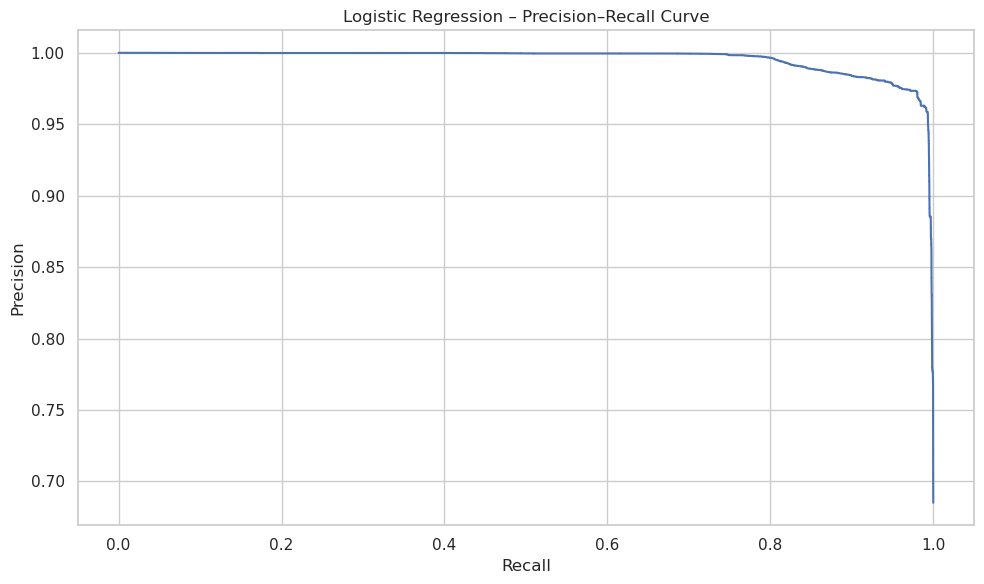

Logistic Regression PR-AUC (test): 0.996


In [76]:
# Confusion matrix – Logistic Regression
cm_lr = confusion_matrix(y_test, y_test_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["benign", "attack"])
disp_lr.plot(values_format="d")
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision–Recall curve – Logistic Regression
precision_lr_curve, recall_lr_curve, _ = precision_recall_curve(y_test, y_test_proba)
plt.plot(recall_lr_curve, precision_lr_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Logistic Regression – Precision–Recall Curve")
plt.tight_layout()

os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/logreg_pr_curve.png", bbox_inches="tight")
plt.show()

print(f"Logistic Regression PR-AUC (test): {logreg_pr_auc:.3f}")

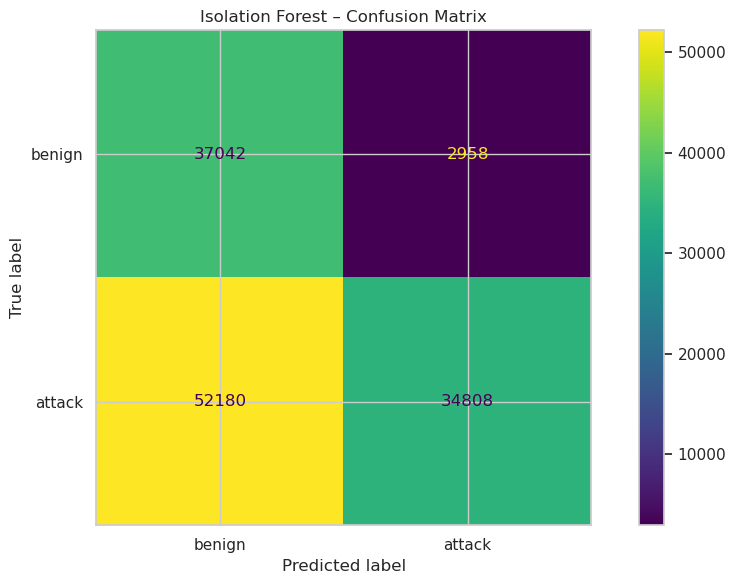

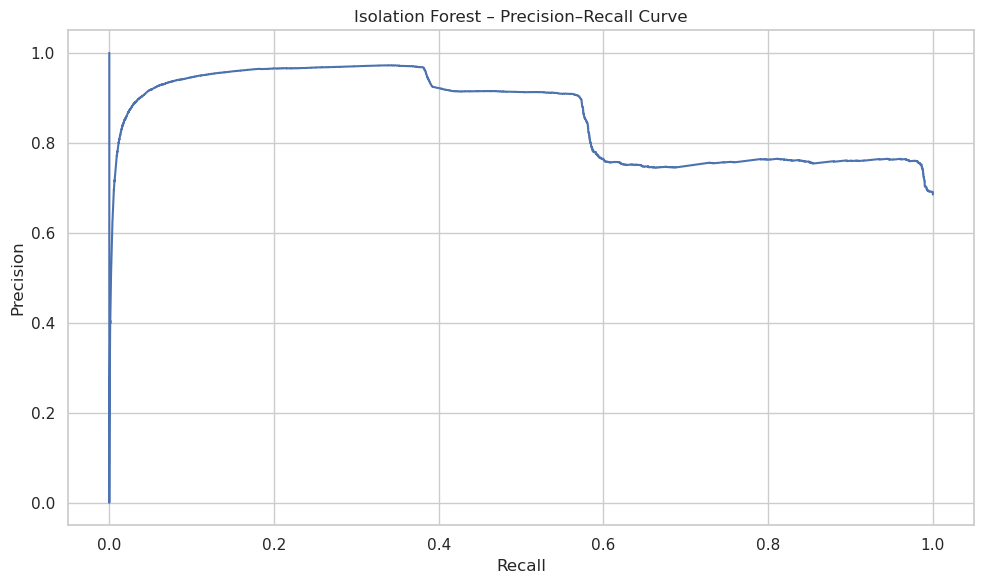

Isolation Forest PR-AUC (test): 0.859


In [77]:
# Confusion matrix – Isolation Forest
cm_iso = confusion_matrix(y_test, iso_y_pred)
disp_iso = ConfusionMatrixDisplay(confusion_matrix=cm_iso, display_labels=["benign", "attack"])
disp_iso.plot(values_format="d")
plt.title("Isolation Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision–Recall curve – Isolation Forest
precision_iso_curve, recall_iso_curve, _ = precision_recall_curve(y_test, iso_scores)
plt.plot(recall_iso_curve, precision_iso_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Isolation Forest – Precision–Recall Curve")
plt.tight_layout()
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/iso_forest_pr_curve.png", bbox_inches="tight")
plt.show()

print(f"Isolation Forest PR-AUC (test): {iso_pr_auc:.3f}")

**Security-oriented interpretation**

- **Logistic Regression**: suitable as a primary detector on this dataset.
  - High attack recall (~0.96) means relatively few missed attacks.
  - High precision (~0.97) keeps false alarms manageable.
  - In an operational SOC, this could feed alerts directly into analyst triage.

- **Isolation Forest**: better viewed as a *supplementary* anomaly score.
  - High precision but low recall: it catches only a subset of attacks, but those it flags are usually true attacks.
  - Useful as a "high-confidence anomaly" signal or as an additional feature into downstream models, rather than a standalone detector.
